# Классификация полей сообщений протокола с нулевым знанием.

Ноутбук для демонстрации реализации алгоритма классификации полей.

Чернышов Юрий, ychernyshov@ussc.ru

# Оглавление <a name='toc'></a>


<ol>
<li><a href='#libs'>Загрузка библиотек</a></li>
<li><a href='#input'>Создание входных данных</a></li>
<li><a href='#embeddings'>Построение числовых векторов-представлений (эмбеддингов) для полей сообщений</a></li>
    <ol>
    <li><a href='#idea'>Описание идеи</a></li>
    <li><a href='#test'>Тестовый трейс небольшого размера</a></li>
    <li><a href='#quality'>Анализ качества разбивки полей</a></li>
    <li><a href='#creation'>Создание эмбеддингов полей протокола</a></li>
    <li><a href='#PCA'>Визуализация</a></li>
    </ol>
<li><a href='#clusterization'>Кластеризация</a></li>
<li><a href='#conclusions'>Выводы</a></li>
<li><a href='#references'>Ссылки</a></li>
</ol>    
    


# Загрузка библиотек <a name='libs'></a>

In [1]:
from math import log
import scipy
from time import time

import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from collections import Counter
import re

import dpkt

<a href='#toc'>Назад к Оглавлению</a>

# Создание входных данных <a name='input'></a>

В качестве исходных данных принимаются границы полей, найденные с использованием энтропии и взаимной информации, алгоритм описан в статье "Выявление аномалий в информационных системах с испольдованием машинного обучения" (Домуховский, Синадский).

Используются функции для определения границ полей, разработанные Алексеем Синадским.

In [3]:
def next_packet_len (packet_length_area):
    degree = 0 # степень при переводе байт в десятичное число
    packet_len = 0 # длина предстоящего пакета
    for octet in packet_length_area:
        tens = octet // 16
        ones = octet % 16
        packet_len += 16 ** degree * (ones + tens * 16)
        degree+=2 # сдвиг на байт
    return packet_len

# выделяет из PCAP-файла все пакеты побайтово
def get_packets_from_pcap (pcap_filename):
    with open(pcap_filename, 'rb') as traffic:
        pcap_data = traffic.read()
    pcap_packets = [] # список пакетов (строк)
    pcap_data_len = len(pcap_data)
    print('pcap_data_len is ' + str(pcap_data_len))
    offset = 24 # первые 24 байта - заголовок PCAP-файла
    while offset < pcap_data_len:
        pcap_packet_header = pcap_data[offset:offset+16] # 16 байт - длина PCAP Packet Header
        offset += 16
        packet_len = next_packet_len(pcap_packet_header[12:16])
        pcap_packets.append(pcap_data[offset:offset+packet_len]) # следующий пакет
        offset += packet_len
    return pcap_packets

# энтропия столбца. На вход нужно подать i-й столбец
def entropy(Di):
    FP = [0] * 256 # frequency pool. Size is 255 because of byte size (max FF)
    for d in Di:
        FP[d] += 1
    H = 0
    N = len(Di)
    for e in FP:
        if e > 0:
            H = H - (e / N) * log(e / N, len(FP))
    return H

# энтропия двух столбцов. На вход нужно подать i-й и (i+1)-й столбцы
def mutual_information(Di, Di1):
    FP_di = [0] * 256 # frequency pool. Size is 256-256 because of two bytes size (max FF in each)
    FP_di1 =[0] * 256
    FP_di_di1 = [0] * 256 * 256
    for di in Di:
        FP_di[di] += 1
    for di1 in Di1:
        FP_di1[di1] += 1
    for i in range(0,len(Di)): # все варианты скрещиваний Di и Di1
        di_di1 = Di[i] * 256 + Di1[i]
        FP_di_di1[di_di1] += 1
    I = 0
    N = len(Di) # одинакова и для Di1, и для виртуального Di_i1
    index = 0 # счётчик
    for i in range(0,len(FP_di)): # от 0 до 256 в первом байте
        if FP_di[i] > 0:
            P_i = FP_di[i] / N # вероятность появления комбинации di
            for j in range(0,len(FP_di1)): # от 0 до 256 во втором байте
                if FP_di_di1[i * 256 + j] > 0:
                    P_i_i1 = FP_di_di1[i * 256 + j] / N # вероятность появления комбинации di_di1
                    P_i1 = FP_di1[j] / N # вероятность появления комбинации di+1
                    I = I + P_i_i1 * log(P_i_i1 / (P_i * P_i1), len(FP_di_di1))
    return I

# сериализация объектов numpy
def data_for_graphs(H, I, max_packet_size):
    x = np.arange(max_packet_size)
    H_shift = H[1:]
    H_shift = np.append(H_shift,[0])
    deltaH = H_shift - H
    deltaH = np.append([0],deltaH)
    deltaH = deltaH[:-1]

    thrH = np.array([1*(i>0.1) for i in deltaH])

    MI_shift = I[1:]
    MI_shift = np.append(MI_shift,[0])

    #TODO: был где-то None, убрал последние два элемента для проверки скрипта
    I = I[0:-2]
    MI_shift = MI_shift[0:-2]

    deltaMI = MI_shift - I
    deltaMI = np.append([0],deltaMI)
    deltaMI = deltaMI[:-1]
    thrMI = np.array([1*(i>0.03) for i in deltaMI])

    deltaH = deltaH[0:-2] #TODO раньше убирал последние два элемента для проверки скрипта, теперь надо и у deltaH убрать
    deltaBoth = np.abs(deltaH) * np.abs(deltaMI) * np.logical_and(np.sign(deltaH), -1 * np.sign(deltaMI))
    deltaBoth = (np.sign(deltaBoth) + 1) * deltaBoth / 2.0
    H = H[0:-2] #TODO также для совместимости
    MI_H_ratio = list(range(len(I))) #TODO и это
    for i in range(0,len(I)):
        if H[i] == 0:
            H[i] = 0.00000001 # если детерминимрованная величина (не изменяется во всём trafficе)
        MI_H_ratio[i] = I[i] / H[i]

    np.savez('res.npy',x=x,H=H,MI=I,deltaH=deltaH,deltaMI=deltaMI,deltaBoth=deltaBoth,MI_H_ratio=MI_H_ratio)
    return(MI_H_ratio, deltaH)

# отрисовка графиков (из сериализованного объекта numpy)
def draw(next_pcap, max_packet_len):
    data = np.load('res.npy.npz',allow_pickle=True)
    fig = go.Figure()
    fig.add_trace(go.Line(x=data['x'][:max_packet_len],y=data['H'][:max_packet_len],name='H' + next_pcap,marker_color='#0000FF'))
    fig.add_trace(go.Line(x=data['x'][:max_packet_len],y=data['MI'][:max_packet_len],name='MI',marker_color='#FF0000'))
    fig.add_trace(go.Line(x=data['x'][:max_packet_len],y=data['deltaH'][:max_packet_len],name='ΔH', marker_color='#00FF00'))
    ####fig.add_trace(go.Line(x=data['x'][:max_packet_len],y=data['deltaMI'][:max_packet_len],name='ΔMI', marker_color='#FF33CC'))
    fig.add_trace(go.Line(x=data['x'][:max_packet_len],y=data['MI_H_ratio'][:max_packet_len],name='MI/H', marker_color='#FF33CC'))
    ####fig.add_trace(go.Line(x=x,y=deltaBoth,name='delta Both'))
    ####fig.add_trace(go.Line(x=x,y=thrH,name='threshold H'))
    ####fig.add_trace(go.Line(x=x,y=thrMI,name='threshold MI'))
    fig.layout.xaxis.nticks = max_packet_len
    fig.layout.xaxis.gridcolor = "#000"
    fig.layout.yaxis.zerolinecolor = "#000"
    fig.layout.yaxis.zerolinewidth = 2
    fig.layout.yaxis.showgrid = False
    data.close()
    fig.show()

# выбирает границы полей
# коэффициенты задаются как глобальные переменные для удобства экспериментирования с ними
#   существующие фигуры:
#       резкий спад и любой подъём
#       любой спад и резкий подъём
#       резкий спад и плавный спад (съезд и подножие)
def choose_border(MI_H_ratio, deltaH):
    # print(MI_H_ratio)
    # print(deltaH)
    border_probability = list(np.zeros(len(deltaH))) # вероятности того, что каждое поле - граница
    for offset in range(len(deltaH)): # для каждого смещения
        if deltaH[offset] < 0.005: # если произошло уменьшение энтропии
            # print('deltaH[', offset, '] is less then 0.005')
            border_probability[offset] += (- deltaH[offset]) + 0.11 # не 0.1 для исправления ошибки при вычислениях
            if check_figure(MI_H_ratio, offset): # если фигура в этом же месте
                border_probability[offset] += 0.6
            if check_figure(MI_H_ratio, offset - 1) or check_figure(MI_H_ratio, offset + 1): # если фигура со сдвигом на 1
                border_probability[offset] += 0.3
            if check_figure(MI_H_ratio, offset - 2) or check_figure(MI_H_ratio, offset + 2): # если фигура со сдвигом на 2
                border_probability[offset] += 0.2
        if check_figure_IPsrc(MI_H_ratio, offset) and deltaH[offset + 1] < -0.3: # если соответствует фигуре IPsrc
            print('offset ', offset, 'is the start of IPsrc')
            border_probability[offset] += 0.64 # то это - начало адреса источника
            border_probability[offset + 1] -= 0.64 # и следующий байт - скорее всего, не граница поля
    borders = list()
    for offset in range(len(deltaH)): # для каждого смещения
        if border_probability[offset] > 0.63: # если вероятность того, что поле является разделителем, больше 63% (получена экспериментально)
            borders.append(offset) # назвать поле разделителем
    return(borders)

# проверяет, соответствует ли отрезок данных фигуре
# возвращает True, если соответствует, иначе False
def check_figure(val, i):
    # коэффициенты для определения границ по графику MIH
    big_coef = 1.1
    small_coef = 1.03
    answer = False
    if i > 0 and i < (len(val) - 1): # проверка на отрицательный индекс
        if val[i-1] > val[i] * big_coef and val[i] <= val[i+1]: # резкий спад и любой подъём (или плато)
            answer = True # то это фигура
        if val[i-1] >= val[i] and val[i] * big_coef < val[i+1]: # любой спад (или плато) и резкий подъём
            answer = True # то это фигура
        if (val[i-1] > val[i] * big_coef and # резкий спад 
            val[i+1] < val[i] < val[i+1] * big_coef): # и спад малой крутизны
            answer = True# то это фигура
    return(answer)
    
# проверяет, соответствует ли отрезок данных фигуре IPsrc
# возвращает True, если соответствует, иначе False
def check_figure_IPsrc(val, i):
    # коэффициенты для определения границ по графику MIH
    big_coef_IPsrc = 20
    answer = False
    if i > 0 and i < (len(val) - 1): # проверка на отрицательный индекс
        if val[i-1] > val[i] * big_coef_IPsrc and val[i] * big_coef_IPsrc < val[i+1]: # резкий спад и резкий подъём
            answer = True # то это фигура
    return(answer)

# получение байтов сетевых пакетов
def get_packets(next_pcap):
    return get_packets_from_pcap(next_pcap)

def count_entropy_for_one_pcap(next_pcap, max_packet_len):
    time_working0 = time()
    packets = list() # список пакетов (строк)
    packets += get_packets(next_pcap)
    print('Время считывания ' + str(time() - time_working0))

    # обрезка всех пакетов по 40 байт
    for i in range(len(packets)):
        packets[i] = packets[i][0:max_packet_len]

    max_packet_size = min(len(i) for i in packets) # максимальный размер пакета
    D = [[] for i in range(max_packet_size)]
    H = [None for i in range(max_packet_size)] # значения энтропии для каждого Di
    I = [None for i in range(max_packet_size)] # значения взаимной информации для каждой пары столбцов Di и Di+1
    V = [0 for i in range(max_packet_size)] # vote

    for offset in range(0,max_packet_size): # для каждого смещения от минимального до максимального
        for packet in packets: # для каждого пакета
            if len(packet) > offset: # если пакет содержит байт по заданному смещению
                D[offset].append(packet[offset]) # добавить его в матрицу
        H[offset] = entropy(D[offset]) # вычисление энтропии для столбца матрицы
    print('Время с расчётом H ' + str(time() - time_working0))
    for offset in range(0,max_packet_size): # для каждого смещения от минимального (начиная с 1) до максимального
        I[offset] = mutual_information(D[offset-1], D[offset])
    print('Время с расчётом I ' + str(time() - time_working0))

    borders = list() # список предполгагаемых границ полей (по отношению MI к H)
    # borders = choose_border(data_for_graphs(H, I, max_packet_size)) # график отношения MI к H
    MIH, deltaH = data_for_graphs(H, I, max_packet_size)
    borders = choose_border(MIH, deltaH)
    print('Время после отрисовки ' + str(time() - time_working0))
    return(borders)

In [8]:
time_script_started = time()
pcaps_list = list()
# pcaps_list.append('traffic/enel.pcap') # в будущем будет получен из аргумента
## pcaps_list.append('traffic/ipx.pcap')
# pcaps_list.append('traffic/simple.pcap')
#pcaps_list.append('traffic/test.pcap')
# pcaps_list.append('traffic/surgut_ks2-traffic.pcap')
# pcaps_list.append('traffic/traf_6k.pcap')
#pcaps_list.append('traffic/traf_36k.pcap')
#pcaps_list.append('traffic/traf_95k.pcap')
#pcaps_list.append('traffic/traf_TCP_len_less_200.pcap')
#pcaps_list.append('traffic/traf_TCP_from_95k_len_less_200.pcap')
#pcaps_list.append('traffic/news_http_small.pcap')
# pcaps_list.append('traffic/news_http_small_g100.pcap')
# pcaps_list.append('traffic/eth_ip_tcp_http_1500.pcap')
pcaps_list.append('/home/datapk/datasets/PRE/test_191_packets.pcap')
# pcaps_list.append('traffic/test_ychernyshov.pcap')
max_packet_len = 90

borders = list() # список списков смещений границ полей 
for next_pcap in pcaps_list:
    print("Анализируемый traffic", next_pcap)
    borders.append(count_entropy_for_one_pcap(next_pcap, max_packet_len))
    print(borders)
    draw(next_pcap, max_packet_len)
    
print('Общее время работы скрипта ' + str(time() - time_script_started))
with open ('borders.txt', 'a') as file_borders:
    for borders_set in borders:
        file_borders.write(str(borders_set))

Анализируемый traffic /home/datapk/datasets/PRE/test_191_packets.pcap
pcap_data_len is 50931
Время считывания 0.0005552768707275391
Время с расчётом H 0.0024652481079101562
Время с расчётом I 0.039335012435913086
Время после отрисовки 0.041931867599487305
[[6, 20, 26, 46]]


/usr/lib/python3/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




Общее время работы скрипта 0.19826555252075195


In [9]:
! ls

borders.txt  fields_classification.ipynb  res.npy.npz
entropy.py   __pycache__		  SOM.ipynb


#### Получение информации о границах полей

In [19]:
fd = open('./borders.txt', 'r')
data = fd.read()
fd.close()
data

'[6, 20, 26, 46]'

In [20]:
data = np.array(data[1:-1].replace(',','').split(), dtype='int')
data = np.r_[np.zeros(1, dtype='int'), data]
borders = np.array([[l, r-1] for l,r in zip(data, data[1:])])
print(borders)

[[ 0  5]
 [ 6 19]
 [20 25]
 [26 45]]


<a href='#toc'>Назад к Оглавлению</a>

# Построение численных векторов-представлений (эмбеддингов) для полей сообщений <a name='embeddings'></a>

#### Описение идеи <a name='idea'></a>

Распознанные на предыдущем шаге поля сообщений сложно классифицировать по стандартным статистическим признакам, поскольку они имеют разную длину, а содержащиеся в полях значения могут существенно отличаться. 

Идея для классификации распознанных полей протокола заключается в определении числовых признаков, позволяющих с как можно большей степенью уверенности относить поле к тому или иному классу, и формировании из этих признаков числовых векторов-представлений полей (аналог эмбеддингов в NLP).

Далее при формировании численных векторов-представлений (эмбеддингов) полей пакета, элементы вектора-представления поля отражают следующие характеристики, позволяющие классифицировать поле: 
- длина поля (поля одного класса имеют одинаковую длину (адреса, типы сообщений), очевидно неверно для информационных полей),

- энтропия значений данного поля (низкая энтропия соответствует небольшому количеству возможных значений на этой позиции, что может указывать на то, что это поле является идентификатором протокола или протокольного сообщения),

- специальная метрика S = IFTF/FF, где FF (Field Frequency) – частота значения в поле  в текущем пакете, IFTF (Inversed Field Traffic Frequency) – частота появления поля во всех других пакетах трафика, исключая позицию в текущем пакете (элементы адресной информации часто встречаются в пакетах и находятся в разных пакетах на разных местах, входящие и исходящие пакеты - адреса источника и получателя меняются местами.

- удаленность левой границы поля от начала пакета, реализует в классификации (адресная информация находится ближе к началу пакета)

- удаленность правой границы поля от начала пакета (информационная часть сообщения находится ближе к концу пакета)


<a href='#toc'>Назад к Оглавлению</a>

#### Анализ качества выделения границ полей на тестовом примере <a name='test'></a>

Тестовый трейс test.pcap содержит 5 стандартных TCP пакетов.

In [22]:
fd = open('/home/datapk/datasets/PRE/test_191_packets.pcap','rb')
pckgs = []
for ts, pckg in dpkt.pcap.Reader(fd):
    pckgs.append(pckg)
fd.close()

In [23]:
for p in pckgs:
    print(" ".join([hex(l) for l in p]))
    print()

0x1 0x0 0xc 0xcc 0xcc 0xcd 0x2c 0x36 0xf8 0x79 0x51 0x9 0x0 0x32 0xaa 0xaa 0x3 0x0 0x0 0xc 0x1 0xb 0x0 0x0 0x0 0x0 0x0 0x62 0x1 0xf4 0x1d 0x6b 0x87 0x5c 0x71 0x0 0x0 0x0 0x3 0x82 0x1 0x2c 0x36 0xf8 0x79 0x51 0x0 0x80 0x9 0x1 0x0 0x14 0x0 0x2 0x0 0xf 0x0 0x0 0x0 0x0 0x0 0x2 0x2 0x1

0xff 0xff 0xff 0xff 0xff 0xff 0xf4 0x1d 0x6b 0x87 0x5c 0x7b 0x8 0x6 0x0 0x1 0x8 0x0 0x6 0x4 0x0 0x1 0xf4 0x1d 0x6b 0x87 0x5c 0x7b 0xa 0x17 0x35 0x1 0x0 0x0 0x0 0x0 0x0 0x0 0xa 0x17 0x35 0xe 0x0 0x0 0x0 0x0 0x0 0x0 0x0 0x0 0x0 0x0 0x0 0x0 0x0 0x0 0x0 0x0 0x0 0x0 0x0 0x0 0x0 0x0 0x0 0x0

0xff 0xff 0xff 0xff 0xff 0xff 0xf4 0x1d 0x6b 0x87 0x5c 0x7b 0x8 0x6 0x0 0x1 0x8 0x0 0x6 0x4 0x0 0x1 0xf4 0x1d 0x6b 0x87 0x5c 0x7b 0xa 0x17 0x35 0x1 0x0 0x0 0x0 0x0 0x0 0x0 0xa 0x17 0x35 0x20 0x0 0x0 0x0 0x0 0x0 0x0 0x0 0x0 0x0 0x0 0x0 0x0 0x0 0x0 0x0 0x0 0x0 0x0 0x0 0x0 0x0 0x0 0x0 0x0

0xff 0xff 0xff 0xff 0xff 0xff 0xf4 0x1d 0x6b 0x87 0x5c 0x7b 0x8 0x6 0x0 0x1 0x8 0x0 0x6 0x4 0x0 0x1 0xf4 0x1d 0x6b 0x87 0x5c 0x7b 0xa 0x17 0x3

Рассматриваем первый пакет трафика

In [24]:
p = pckgs[0]
eth = dpkt.ethernet.Ethernet(p)
eth

Ethernet(dst=b'\x01\x00\x0c\xcc\xcc\xcd', src=b',6\xf8yQ\t', type=50, len=50, data=LLC(oui=12, type=267, data=b'\x00\x00\x00\x00\x00b\x01\xf4\x1dk\x87\\q\x00\x00\x00\x03\x82\x01,6\xf8yQ\x00\x80\t\x01\x00\x14\x00\x02\x00\x0f\x00\x00\x00\x00\x00\x02\x02\x01'))

MAC адреса

In [25]:
[hex(l) for l in eth.dst], [hex(l) for l in eth.src]

(['0x1', '0x0', '0xc', '0xcc', '0xcc', '0xcd'],
 ['0x2c', '0x36', '0xf8', '0x79', '0x51', '0x9'])

Данные IP протокола

In [26]:
ip = eth.data
ip

LLC(oui=12, type=267, data=b'\x00\x00\x00\x00\x00b\x01\xf4\x1dk\x87\\q\x00\x00\x00\x03\x82\x01,6\xf8yQ\x00\x80\t\x01\x00\x14\x00\x02\x00\x0f\x00\x00\x00\x00\x00\x02\x02\x01')

IP адреса

In [27]:
[hex(l) for l in ip.src], [hex(l) for l in ip.dst]

AttributeError: 'LLC' object has no attribute 'src'

<a href='#toc'>Назад к Оглавлению</a>

#### Анализ качества разбивки полей <a name='quality'></a>

In [21]:
for i, b in enumerate(borders):
    print(i, b, [hex(l) for l in p[b[0]:b[1]+1]])

0 [0 5] ['0xd0', '0xd', '0x10', '0xf0', '0x48', '0xa2']
1 [ 6 19] ['0x0', '0x0', '0x5e', '0x0', '0x1', '0x0', '0x8', '0x0', '0x45', '0x60', '0x0', '0x28', '0xbd', '0xd8']
2 [20 25] ['0x40', '0x0', '0x78', '0x6', '0x92', '0x80']
3 [26 45] ['0x4f', '0x87', '0x57', '0xfc', '0xa', '0x80', '0x0', '0x14', '0x9d', '0xc4', '0x0', '0x16', '0x34', '0xbe', '0xcd', '0xfc', '0x72', '0x16', '0x1d', '0x8b']


Анализ правильности разбивки и разметка для обучения с учителем: 

- (0,5), (6,11) <b><font color='green'>правильно</font></b> определены MAC адреса источника (0,5) и получателя (6,11), в разметке устанавливаем <b>target=1</b>

- (12, 15) IP type "0х08 0x00" не распознан (входит в состав поля (12,15)), однако остальная часть "0x45 0x60" является бит-ориентированной служебной частью протокола IP, предварительно поле (12, 15) рассматриваем как идентификационное поле, <b>target=2</b>

- (16, 16) <b><font color='red'>неправильно</font></b> выделено в отдельное поле - данный байт является частью поля длины "0x00 0x28" (Total length 40), <b>target=0</b>

- (17, 23) на позиции 17 содержит второй байт поля длины ("0x28"), содержит различную служебную информацию и идентификатор протокола на 23 позиции "0x06", уточнить почему не выделяется идентификатор протокола, <b>target=0</b>

- (24, 26) содержит checksum "0x92 0x80" и <b><font color='red'>неправильно</font></b> добавленный первый байт IP адреса источника "0x4f", <b>target=0</b>

- (27,29), (30,33) <font color='red'><b>ошибка</b></font> в определении границ IP адреса источника (27,29) (должно быть (26,29)), но <b><font color='green'>правильно</font></b> опреден IP адрес назначения (30,33), <b>target=1</b>

- (34, 35) <b><font color='green'>правильно</font></b> определен порт источника "0x9d 0xc4", <b>target=1</b>

- (36, 44) <b><font color='red'>не выделен</font></b> destination port "0x00 0x16", sequence number "0x34 0xbe 0xcd 0xfc", ack number "0x72 0x16 0x1d" - <b><font color='red'>не хватает</font></b> одного байта (выделен отдельно в следующий пакет), <b>target=0</b>

- (45) "0x8b" <b><font color='red'>ошибочно</font></b> отдельно показан последний байт TCP ack number, <b>target=0</b>

- (46, 48) "0x50 0x10" flags, бит-ориентированная информация, "0x01" первый бит window size value, <b>target=0</b>

- (49) "0xfb" второй бит window size value, <b>target=0</b>

- (50, 51) <b><font color='green'>правильно</font></b> выделенный checksum, <b>target=0</b>

- (52, 55) "0x00 0x00" - часть служебной информации TCP, "0x5d 0x8f" - VSS monitoring ethernet trailer (информационная часть, которую надо выделять), <b>target=0</b>

В дальнейшем определенные поля классифицируются как

- адресное поле (target=1)

- идентификатор (target=2)

- поле, связанное с длинной (длина сообщения, поля, пакета и пр.) (target=3)

- информационная часть (target=0)

Определим соответствующую разметку (1 - адресная информация второго уровня (MAC), 2 - идентификатор, 3 - адресная информация третьего уровня (IP), 0 - прочее)


In [102]:
labels = [1, 1, 2, 0, 0,
          0, 1, 1, 1, 0,
          0, 0, 0, 0, 0]

<a href='#toc'>Назад к Оглавлению</a>

#### Создание эмбеддингов полей протокола <a name='creation'></a>

In [104]:
def create_embeddings(pckgs, borders):

    embeddings = []
    
    for i, b in enumerate(borders):
        tmp = []
        
        # 1. Relative field Length (field length / packet length)
        #tmp.append(b[1]-b[0]+1)

        # 2. Vocabulary length - количество уникальных значений в разных пакетах для данного поля
        c = Counter([elem[borders[i,0]:borders[i,1]+1] for elem in pckgs])
        tmp.append(len(c.keys()))
                
        # 3. Entrophy
        H = 0
        for value in c.values():
            H += - value/len(pckgs)*np.log(value/len(pckgs))
        tmp.append(H)
        
        # 4.1. FF (Field Frequency) - насколько часто значение, находящееся в текущем рассматриваемом поле,
        # встречается в текущем рассматриваемом пакете на других позициях
        FF = 0
        for j in range(len(pckgs)):        
            word = pckgs[j][borders[i,0]:borders[i,1]+1]
            for k in range(len(pckgs[j])-len(word)):
                if word==pckgs[j][k:k+len(word)]:
                    FF += 1
        FF /= len(pckgs)
        
        # 4.2. IFTF (Inversed Field Traffic Frequency) - насколько часто значение, находящееся в текущем рассматриваемом поле,
        # встречается в других пакетах, кроме рассматриваемой позиции
        IFTF = 0
        for j in range(len(pckgs)):        
            word = pckgs[j][borders[i,0]:borders[i,1]+1]
            for k in range(len(pckgs)):
                if not k==j:
                    for l in range(len(pckgs[k])-len(word)):
                        if not l==borders[i,0]:
                            if word==pckgs[k][l:l+len(word)]:
                                IFTF += 1
        IFTF /= len(pckgs)
        tmp.append(IFTF/FF)

        # 6. left
        tmp.append(b[0])

        # 7. right
        tmp.append(b[1])

        embeddings.append(tmp)
    
    embeddings = np.array(embeddings)
    
    return(embeddings)

In [131]:
fd = open('/home/datapk/datasets/PRE/test_191_packets.pcap','rb')
big_pckgs = []
for ts, pckg in dpkt.pcap.Reader(fd):
    big_pckgs.append(pckg)
fd.close()

embeddings = create_embeddings(big_pckgs, borders)

In [179]:
for i,e in enumerate(embeddings):
    print(i, ": ", "\t\t".join([str(round(d,3)) for d in e]))

0 :  9.0		1.466		1.047		72.037
1 :  12.0		1.398		1.225		62.838
2 :  6.0		0.837		1.0		0.016
3 :  6.0		1.395		25.089		5048.827
4 :  138.0		4.456		1.366		32.723
5 :  136.0		4.43		2.063		520.623
6 :  25.0		2.255		8.44		255.267
7 :  22.0		2.309		1.497		96.272
8 :  32.0		2.766		5.157		991.948
9 :  145.0		4.813		1.346		28.026
10 :  74.0		3.533		15.487		2455.042
11 :  48.0		3.126		4.822		857.45
12 :  38.0		2.879		10.623		2828.435
13 :  133.0		4.255		5.623		1365.152
14 :  56.0		2.409		24.168		2731.277


Нормализация столбцов

In [124]:
for i in range(len(borders)):
    for j in range(7):
        m = np.mean(embeddings[:,j])
        v = np.var(embeddings[:,j])
        embeddings[i,j] =  (embeddings[i,j]-m)/v
        
embeddings

array([[-1.89003146e-02, -9.04985101e-01, -9.90601491e-02,
        -5.27098394e-04],
       [-1.71080962e-02, -5.56163132e-01, -9.34690947e-02,
        -5.26487373e-04],
       [-1.84709212e-02, -5.96475323e-01, -9.39177757e-02,
        -5.52338252e-04],
       [-1.80442453e-02, -3.16301913e-01,  2.74067823e-01,
         1.87809469e-03],
       [ 2.84913034e-02,  5.73723836e-01, -9.00954653e-02,
        -7.50281094e-04],
       [ 3.48485567e-02,  6.65987185e-01, -7.07994065e-02,
        -2.76791761e-04],
       [-6.32172651e-03,  1.35965578e-01,  7.10232554e-02,
        -4.81403438e-04],
       [-6.69426549e-03,  1.87131330e-01, -6.51523486e-02,
        -6.01071968e-04],
       [-1.36617121e-03,  3.52804497e-01,  1.42956090e-02,
         2.17893757e-04],
       [ 4.82962694e-02,  9.93478208e-01, -5.65466563e-02,
        -5.77026309e-04],
       [ 3.47036947e-02,  9.22499479e-01,  2.29777043e-01,
         1.55495027e-03],
       [ 2.27833940e-02,  9.91609452e-01,  4.39920988e-02,
      

<a href='#toc'>Назад к Оглавлению</a>

#### Визуализация <a name='PCA'></a>

Проанализируем расположение векторов с помощью метода анализа главных компонент, PCA с двумя компонентами (для удобства визуализации).

In [181]:
pca = PCA(n_components=2)
tsne = TSNE()
pca_r = pca.fit_transform(embeddings)
tsne_r = tsne.fit_transform(embeddings)

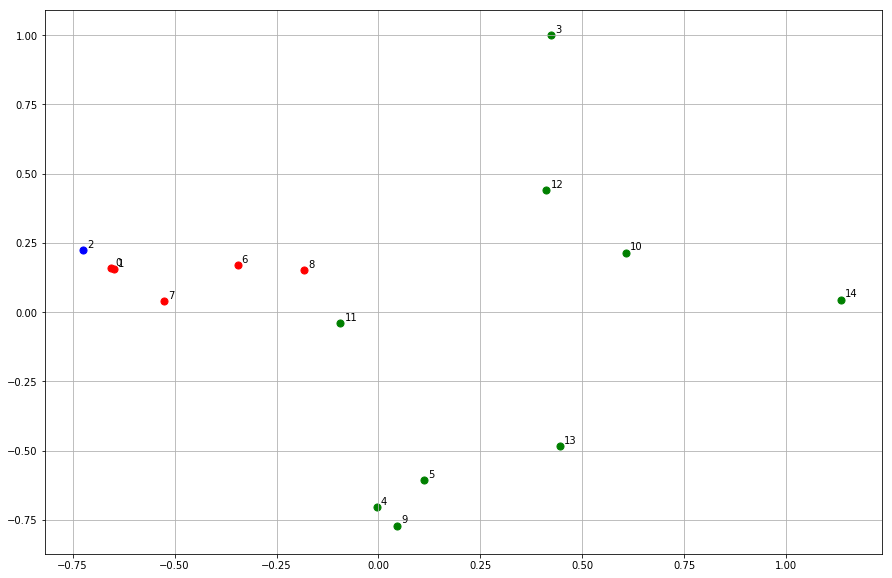

In [184]:
result = pca_r
plt.figure(figsize=(15,10))
for i in range(len(result)):
    if labels[i]==1:
        color = 'r'
    elif labels[i]==2:
        color = 'b'
    else:
        color = 'g'
    plt.scatter(result[i,0], result[i,1], c=color, s=50)
    plt.text(result[i,0]+0.01, result[i,1]+0.01, str(i))
plt.grid(True)
plt.show()

In [197]:
for i in [0, 2, 8, 11, 12]:
    print("\t".join([str(round(e,2)) for e in embeddings[i]]))

0.06	0.3	0.04	0.01
0.04	0.17	0.04	0.0
0.22	0.57	0.21	0.35
0.36	0.73	0.2	0.3
0.29	0.68	0.44	1.0


In [185]:
for i in range(15):
    print(i, scipy.spatial.distance.euclidean(embeddings[2],embeddings[i]))

0 0.13305956390052268
1 0.12452292490961227
2 0.0
3 1.3911565027386532
4 1.1808614251933316
5 1.1818762439391062
6 0.4558902315890716
7 0.32762950716563066
8 0.588124930812393
9 1.265574193531563
10 1.3455242695995555
11 0.7306565195759834
12 1.213310830193171
13 1.3741631636409566
14 1.8770178388133565


<a href='#toc'>Назад к Оглавлению</a>

# Кластеризация <a name='clusterization'></a>

In [158]:
from sklearn.cluster import KMeans

In [159]:
embeddings.shape

(15, 4)

In [160]:
kmeans = KMeans(n_clusters=3).fit(embeddings)

In [161]:
kmeans.labels_

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2], dtype=int32)

In [162]:
labels, list(kmeans.labels_)

([1, 1, 2, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2])

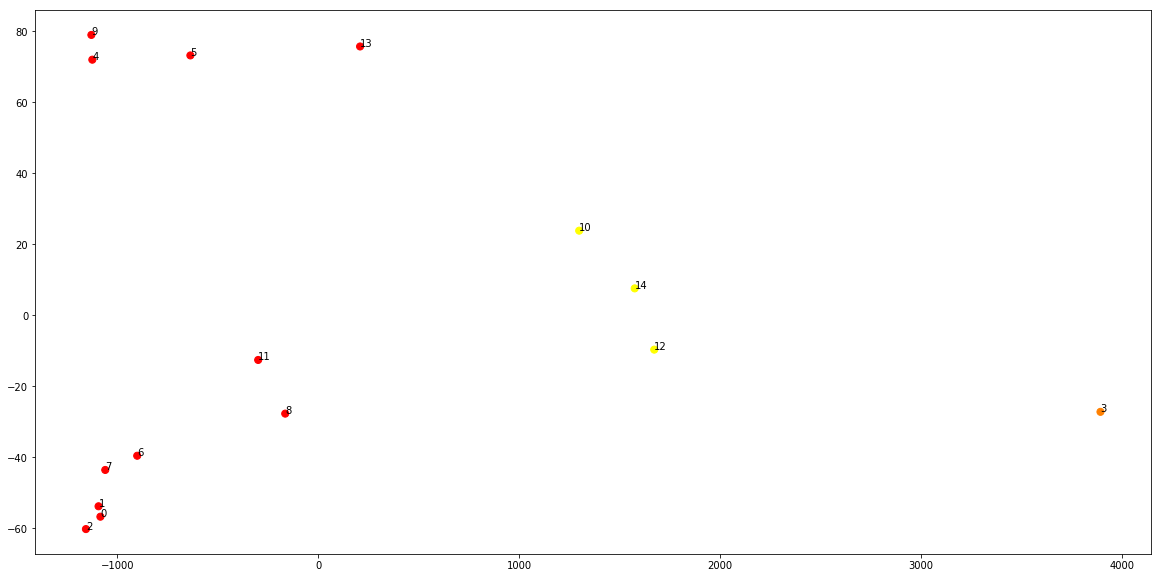

In [163]:
plt.figure(figsize=(20,10))
#plt.scatter(result[:,0], result[:,1], c=labels, s=300, cmap='autumn')
plt.scatter(result[:,0], result[:,1], c=kmeans.labels_, s=50, cmap='autumn')
for i, _ in enumerate(labels):
    plt.text(result[i,0]+0.01, result[i,1]+0.01, i)

<a href='#toc'>Назад к Оглавлению</a>

# Выводы <a name='conclusions'></a>

<a href='#toc'>Назад к Оглавлению</a>

# Ссылки <a name='references'></a>

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

T. Kohonen (Finnland). The Self-Organizing Maps. 1990. Источник: https://sci2s.ugr.es/keel/pdf/algorithm/articulo/1990-Kohonen-PIEEE.pdf

<a href='#toc'>Назад к Оглавлению</a>